In [1]:
import cv2 as cv
import os
import IPython.display as ipd

import json

import numpy as np

import keras

from keras.preprocessing import image as kimage
from keras.applications import resnet_v2
from keras.models import Model
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Imports for face alignment
# How to install:
#    pip install imutils
#    conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [3]:
import utils_2d

## Dlib Detector and Predictor

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

Model choices:

- "30": Basic convlutional architecture
- "31_maxpool": Basic convlutional architecture + maxpool layer
- "32_doublesteps": Basic convlutional architecture + maxpool layer + doubled steps per epoch

In [5]:
model_name = "31_maxpool"
model, labels, preprocess_fun = utils_2d.load_model(model_name)

In [6]:
labels

array(['alessandro', 'alinda', 'cami', 'gian', 'khaled', 'luca', 'mamma',
       'papi'], dtype='<U10')

# Test with webcam

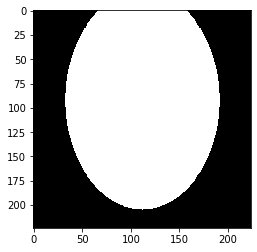

In [7]:
mask = utils_2d.create_mask()
plt.imshow(mask, cmap="gray")
plt.show()

In [8]:
def test_model(model, labels, mask, preprocess_fun = preprocess_fun, model_number = model_name,
               basedir = "test_pictures", new_width=200, mirror=True, more_space=10, threshold = 50):
    
    if not os.path.isdir(basedir):
        print(f"Created new directory {basedir}")
        os.makedirs(basedir)

    current_images = [img for img in os.listdir(basedir) if (img.endswith(".png") and img.startswith(str(model_number)))]
    
    filename_format = f"{basedir}/{model_number}_"+"{}.png"
    
    i = utils_2d.find_last_filename_id(current_images)
    
    labels = np.array(labels)
    cap = cv.VideoCapture(0)
    while(True):
        
        r, frame = cap.read()
        if mirror:
            frame = cv.flip(frame, 1)
        
        try:
            frame = add_box(frame, model, labels, mask, preprocess_fun, new_width, more_space, threshold)
            cv.imshow('Video', frame)
            
        except Exception as e:
            print(e)
            pass
        
        key = cv.waitKey(1)
        
        if (key & 0xFF) == ord('s'):            
            i += 1
            filename = filename_format.format(i)
            cv.imwrite(filename, frame)
            ipd.clear_output(wait=True)
            print(f"Saved {filename}".replace("//", "/"))
        
        elif (key & 0xFF) == ord('q'):
            break
            
    cap.release()
    cv.destroyAllWindows()

In [9]:
def add_box(img, model, labels, mask, preprocess_fun = preprocess_fun, new_width=200, more_space=10, threshold=50):
    m = more_space
    
    fontColors = [(0,0,255), (255,160,0), (0,255,0),
                  (0,255, 255), (193,182,255)]
    fontScale              = 2
    lineType               = 2
    font                   = cv.FONT_HERSHEY_PLAIN
    
    if img is not None:
        
        face = 0
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        og_width = gray.shape[1]
        scaler = og_width/new_width
        gray = imutils.resize(gray, width = new_width)

        faces = detector(gray, 2) # check: what is the 2
        
        for rect in faces:
            
            
            (x, y, w, h) = rect_to_bb(rect)
            
            gray2 = utils_2d.preprocess_face(gray, mask, fa, rect, equalize=True)
            
            gray2 = preprocess_fun(gray2)
            
            # # uncomment to test if the preprocessing is working
            # plt.imshow(gray2, cmap="gray")
            # plt.show()
            
            # rescale box
            (x, y, w, h) = (np.array((x,y,w,h))*scaler).astype(int)
                
            # make prediction
            pred = model.predict(gray2[np.newaxis,:,:, np.newaxis])[0]            
            text = labels[np.argmax(pred)]
            
            # no prediction if model's confidence below threshold
            conf = pred[np.argmax(pred)]*100
            if conf < threshold:
                text = "?"
                
            # add box and text
            topLeftCornerOfText = (x-m,y-m-5)
            bottomLeftCornerOfText = (x-m,y+h+35)    
            fontColor              = fontColors[face]
            face += 1
                  
            cv.rectangle(img,(x-m,y-m),(x+w+m,y+h+m),fontColor,2)
            cv.putText(img, f"{text}", topLeftCornerOfText,
                       font, fontScale, fontColor, lineType)
            cv.putText(img, f"{conf:.2f}%", bottomLeftCornerOfText,
                       font, fontScale, fontColor, lineType)
                    
    return img

`new_width` is the width of the resized image passed to the dlib detector.

Smaller values mean smoother webcam preview, but prediction is slightly affected.

OK values are between 150/250 depending on how far the face is from the webcam

In [ ]:
basedir=f"webcam_pictures/"
test_model(model,labels, mask, new_width=100, threshold=50, basedir=basedir)

## Test single shot

In [10]:
def test_model_single_shot(model,labels, mask, preprocess_fun = preprocess_fun,
                           new_width=200, threshold=50, mirror = True):
    
    cap = cv.VideoCapture(0)
    result, img = cap.read()
    
    if mirror:
            img = cv.flip(img, 1)
    
    cap.release()
    
    img2 = add_box(img, model, labels, mask, preprocess_fun, new_width, threshold=threshold)[:,:,::-1]
    
    plt.figure(figsize=(14,7))
    plt.imshow(img2)
    plt.show()
    
    return img2

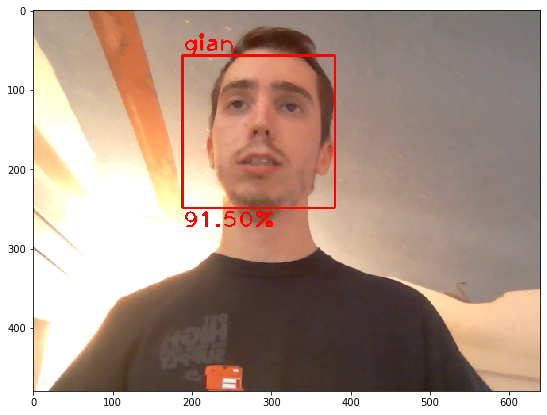

In [11]:
img = test_model_single_shot(model, labels, mask, threshold=50)

# Test Directories

In [12]:
def test_directory(name, basedir, labels, model, mask, preprocess_fun=preprocess_fun, new_width=200):
    # might make sense to test on some pictures not used during training
    
    srcdir = basedir+"/"+name
    counts={}
    for label in labels:
        counts[label] = 0
    total = 1
    
    for file in os.listdir(srcdir):
        img = cv.imread(srcdir+"/"+file)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray = cv.equalizeHist(gray)
        gray = imutils.resize(gray, new_width)
        faces = detector(gray, 2)
        if len(faces)>0:
            rect = faces[0]
            gray2 = fa.align(gray, gray, rect)
        else:
            # only make a prediction if a face is detected by dlib
            continue
        
        gray2[~mask] = 0
        gray2 = preprocess_fun(gray2)
        
        pred = model.predict(gray2[np.newaxis,:,:, np.newaxis])[0]            
        text = labels[np.argmax(pred)]
        
        counts[text] += 1
        ipd.clear_output(wait=True)
        for i in counts.keys():
            print("{:10s}: {:>2d}".format(i, counts[i]))
        print(f"\nFaces detected by dlib: {total}/100")
        print("Accuracy: ", counts[name]/total)
        total += 1

Make predictions on pictures not used during training:

(note: a prediction is not made if dlib does not detect a face)

In [13]:
%%time
test_directory("alessandro", "test_pictures", labels, model, mask, new_width=110)

alessandro: 69
alinda    :  0
cami      :  4
gian      :  0
khaled    :  4
luca      :  0
mamma     :  0
papi      :  4

Faces detected by dlib: 81/100
Accuracy:  0.8518518518518519
CPU times: user 24.4 s, sys: 43.9 s, total: 1min 8s
Wall time: 8.95 s


In [14]:
%%time
test_directory("alinda", "test_pictures", labels, model, mask, new_width=110)

alessandro:  0
alinda    : 48
cami      :  1
gian      :  0
khaled    :  0
luca      :  4
mamma     :  0
papi      :  3

Faces detected by dlib: 56/100
Accuracy:  0.8571428571428571
CPU times: user 24.7 s, sys: 41.8 s, total: 1min 6s
Wall time: 8.92 s


In [15]:
%%time
test_directory("cami", "test_pictures", labels, model, mask, new_width=110)

alessandro:  0
alinda    : 65
cami      : 30
gian      :  0
khaled    :  0
luca      :  0
mamma     :  0
papi      :  5

Faces detected by dlib: 100/100
Accuracy:  0.3
CPU times: user 30 s, sys: 51.3 s, total: 1min 21s
Wall time: 10.6 s


In [16]:
%%time
test_directory("gian", "test_pictures", labels, model, mask, new_width=110)

alessandro: 10
alinda    :  0
cami      :  0
gian      : 55
khaled    :  0
luca      : 30
mamma     :  0
papi      :  1

Faces detected by dlib: 96/100
Accuracy:  0.5729166666666666
CPU times: user 44.5 s, sys: 1min 15s, total: 2min
Wall time: 15.7 s


In [17]:
%%time
test_directory("khaled", "test_pictures", labels, model, mask, new_width=110)

alessandro:  8
alinda    :  0
cami      :  0
gian      :  1
khaled    : 42
luca      : 11
mamma     :  0
papi      :  0

Faces detected by dlib: 62/100
Accuracy:  0.6774193548387096
CPU times: user 36.4 s, sys: 59.7 s, total: 1min 36s
Wall time: 13.9 s


In [18]:
%%time
test_directory("luca", "test_pictures", labels, model, mask, new_width=110)

alessandro:  6
alinda    :  2
cami      : 28
gian      :  2
khaled    :  3
luca      : 55
mamma     :  0
papi      :  3

Faces detected by dlib: 99/100
Accuracy:  0.5555555555555556
CPU times: user 38.9 s, sys: 1min 9s, total: 1min 48s
Wall time: 14.1 s


In [19]:
%%time
test_directory("mamma", "test_pictures", labels, model, mask, new_width=110)

alessandro:  0
alinda    :  0
cami      : 13
gian      :  2
khaled    :  2
luca      :  0
mamma     : 55
papi      :  3

Faces detected by dlib: 75/100
Accuracy:  0.7333333333333333
CPU times: user 26.8 s, sys: 46.2 s, total: 1min 13s
Wall time: 9.59 s


In [20]:
%%time
test_directory("papi", "test_pictures", labels, model, mask, new_width=110)

alessandro:  1
alinda    :  0
cami      :  5
gian      :  0
khaled    :  5
luca      :  0
mamma     :  0
papi      : 62

Faces detected by dlib: 73/100
Accuracy:  0.8493150684931506
CPU times: user 32.1 s, sys: 56.2 s, total: 1min 28s
Wall time: 11.7 s
